In [19]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
import requests 
import time
warnings.filterwarnings("ignore", category=UserWarning, module='urllib3')

## Plots:

We currently have plots that demonstrate:
- Each sector's market share
- History/average prices by sector
- Correlation between sectors
- average closing price


Market Share Breakdown for 2024-02-26:       [M->Millions, B->Billions, T->Trillions]
Total Market Capitalization: $13.5T
Technology: $5.7T (42.19%)
Consumer Cyclical: $2.5T (18.52%)
Healthcare: $1.7T (12.71%)
Financial Services: $1.5T (11.29%)
Energy: $982.9B (7.26%)
Communication Services: $799.5B (5.90%)
Industrials: $289.7B (2.14%)


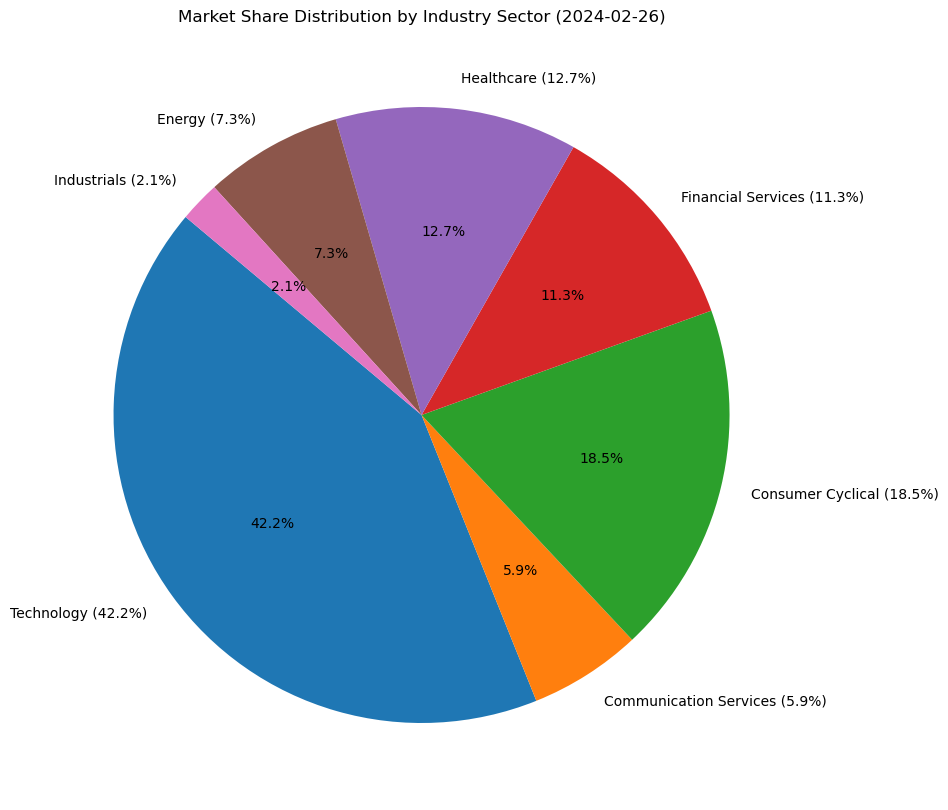


Returned Data: {'total_market_cap': 13546441907879.252, 'industry_market_caps': defaultdict(<class 'float'>, {'Technology': 5715303414772.125, 'Communication Services': 799547411866.3594, 'Consumer Cyclical': 2508646067059.191, 'Financial Services': 1529203928568.8574, 'Healthcare': 1721137402982.2944, 'Energy': 982897844341.1357, 'Industrials': 289705838289.2871}), 'industry_percentages': {'Technology': 42.19043977480045, 'Communication Services': 5.9022687824860105, 'Consumer Cyclical': 18.518855977967497, 'Financial Services': 11.288602121265512, 'Healthcare': 12.70545737904209, 'Energy': 7.255763919597484, 'Industrials': 2.1386120448409445}}


In [20]:
# Plotting 
from collections import defaultdict
from datetime import datetime, timedelta
def human_readable(num):
    """Converts large numbers to human-readable format (e.g., 1.2B, 32.5M)"""
    if num >= 1_000_000_000_000:
        return f"{num / 1_000_000_000_000:.1f}T"
    if num >= 1_000_000_000:
        return f"{num / 1_000_000_000:.1f}B"
    elif num >= 1_000_000:
        return f"{num / 1_000_000:.1f}M"
    else:
        return f"{num:,.2f}"

def plot_market_share_by_sector(date: str, tickers=None):
    """
    Generates a pie chart of market share distribution by industry sector for a given date
    and prints additional statistics in a human-readable format.

    Parameters:
        date (str): The target date in 'YYYY-MM-DD' format.
        tickers (list, optional): List of company tickers to analyze.
    
    Returns:
        dict: Contains sector market caps, total market cap, and percentage breakdown.
    """
    if tickers is None:
        tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA',  # Tech
                   'JPM', 'V', 'BAC', 'WFC', 'GS',  # Finance
                   'JNJ', 'PFE', 'MRNA', 'UNH', 'LLY',  # Healthcare
                   'XOM', 'CVX', 'BP', 'COP', 'PSX',  # Energy
                   'UPS', 'FDX', 'CSX', 'NSC', 'DPZ']  # Shipping/Transport

    industry_data = defaultdict(float)
    
    # Convert string date to datetime and get the next day
    target_date = datetime.strptime(date, "%Y-%m-%d")
    next_day = target_date + timedelta(days=1)
    
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        info = stock.info
        industry = info.get('sector', 'Unknown')  # Get sector
        
        # Fetch historical price around the given date
        try:
            historical_data = stock.history(start=date, end=next_day.strftime("%Y-%m-%d"))
            
            if historical_data.empty:
                print(f"Skipping {ticker}: No data for {date}")
                continue
            
            close_price = historical_data['Close'].iloc[0]  # Closing price
            shares_outstanding = info.get('sharesOutstanding', 0)  # Number of shares
            
            market_cap = close_price * shares_outstanding  # Calculate market cap
            
            if market_cap > 0:
                industry_data[industry] += market_cap
        
        except Exception as e:
            print(f"Skipping {ticker}: Error fetching data - {e}")

    # If no valid data was retrieved, return
    if not industry_data:
        print("No valid market cap data found for the given date.")
        return
    
    # Calculate total market cap
    total_market_cap = sum(industry_data.values())

    # Generate percentage breakdown
    industry_percentages = {sector: (cap / total_market_cap) * 100 for sector, cap in industry_data.items()}
    
    # Print statistics with human-readable formatting
    print(f"\nMarket Share Breakdown for {date}:       [M->Millions, B->Billions, T->Trillions]")
    print(f"Total Market Capitalization: ${human_readable(total_market_cap)}")
    
    for sector, cap in sorted(industry_data.items(), key=lambda x: x[1], reverse=True):
        percentage = industry_percentages[sector]
        print(f"{sector}: ${human_readable(cap)} ({percentage:.2f}%)")

    # Extract labels and sizes for the pie chart
    labels = [f"{sector} ({percentage:.1f}%)" for sector, percentage in industry_percentages.items()]
    sizes = industry_data.values()

    # Create pie chart
    plt.figure(figsize=(10, 10))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"Market Share Distribution by Industry Sector ({date})")
    plt.show()
    
    return {
        "total_market_cap": total_market_cap,
        "industry_market_caps": industry_data,
        "industry_percentages": industry_percentages
    }

# Example usage:
stats = plot_market_share_by_sector("2024-02-26")

# Example of accessing returned data:
if stats:
    print("\nReturned Data:", stats)

## Central Motivation for project
 - Useable tool to help people navigate the stock market
 - See if there is a correlation between price movement in different sectors
 - Predict stock prices based off historical data 

## 2 Key Questions
- Is there a correlation between the performance of different sectors/industries?
- Can you reasonably predict stock price based only on past stock data?


In [21]:
import requests
from bs4 import BeautifulSoup
import time

In [22]:
#getting all the tickers in the s&p 500 for our data
tickers = []
response = requests.get('https://stockanalysis.com/list/sp-500-stocks/').text
soup = BeautifulSoup(response)
stocks = soup.findAll('td', class_ = 'sym svelte-utsffj')
for stock in stocks:
    tickers.append(stock.find('a').text)

C:\Users\milol\AppData\Local\Temp\ipykernel_2460\3299784483.py:5: DeprecationWarning:

Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.



In [23]:
#getting the stock data for each stock in our tickers list, and adding it to a master dataframe
data_list = []

for ticker in tickers:
    stock = yf.Ticker(ticker)
    hist = stock.history(period="5y")  
    hist["Ticker"] = ticker  
    stock_info = stock.info

    hist['Sector'] = stock_info.get('sector', 'None')
    hist['Industry'] = stock_info.get('industry', 'None')
    data_list.append(hist)

    time.sleep(0.301)

df = pd.concat(data_list)
df.reset_index(inplace=True)
df.to_csv('stock_data.csv', index=False)

$BRK.B: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")
Could not get exchangeTimezoneName for ticker 'TSCO' reason: 'chart'
$TSCO: possibly delisted; no price data found  (period=5y)
$BF.B: possibly delisted; no price data found  (period=5y)
401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MTCH?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MTCH&crumb=Edge%3A+Too+Many+Requests


AttributeError: 'NoneType' object has no attribute 'update'

In [ ]:
#group data by sector so we can see how different sectors perform over time and spot patterns/trends
group = 'Sector'
grouped_data = df[['Date', 'Close', group]].groupby(['Date', group]).mean()
grouped_data.reset_index(inplace=True)

In [ ]:
#Plots the average price of each sector over the last 5 years. 
fig = px.line(grouped_data, x='Date', y='Close', color=group, 
              title = f'Historical adjusted close price of stocks, grouped by {group}',
              labels = {
                  'date' : 'Date',
                  'close' : 'Closing price (adjusted)'
                })
fig

In [ ]:
#transform grouped df so it can be used for making a heatmap
pivot_df = grouped_data.pivot(index='Date', columns='Sector', values='Close')

# Calculate correlations
correlation = pivot_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Sectors")
plt.show()

Shows us which stocks tend to move together, and how someone can diversify their portfolio if they pick stocks with 0 or negative correlations. Essentially the heatmap displays the correlation between the stock prices of different companies.

In [ ]:
# Plotting the moving average closing price for s&p 500 since the start of our data
avg1 = grouped_data['Close'].rolling(100).mean()
plt.figure(figsize=(12,6))
plt.plot(avg1, 'blue', label='Moving Average 100 days')
plt.legend(loc='upper left')
plt.xlabel(f'Days since 02/28/25')
plt.ylabel('Price')
plt.show()